# Evolutionary Simulators: From Chemostats to Chromosomes

---
**Nadav Ben Nun** &nbsp;|&nbsp; *Gresham Lab (NYU) · Selmecki Lab (UMN)*

---

Different biological questions — and different experimental systems — require different
computational models. This notebook traces five simulators developed for experimental
evolution.

| # | Paper | Model | System |
|---|-------|-------|--------|
| 1 | **Avecilla et al.** | 3-genotype Wright-Fisher | Chemostat (continuous culture) |
| 2 | **Avecilla et al.** | Chemostat ODE (Monod) | Chemostat (continuous culture) |
| 3 | **Chuong et al.** | 4-genotype Wright-Fisher | Discrete-generation batch |
| 4 | **De et al.** | 2-genotype Wright-Fisher | CNV reversion |
| 5 | **Zhou et al.** | Aneuploidy stability WF | Trisomic → diploid / LOH |

Each section follows the same structure:
1. **Empirical data** — what was measured
2. **Model** — equations and diagram
3. **Model fit** — simulations with $\theta + \mathcal{N}(0,\sigma)$ noise to replicate group dynamics

---
### Running on Google Colab

Upload the entire `tutorials/` folder to Google Drive, then open this notebook in Colab.
All data and code are bundled — no server connection required.


In [424]:
import sys, warnings, os
warnings.filterwarnings('ignore')

# evo_model.py lives in the same directory as this notebook
sys.path.insert(0, '.')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.integrate import odeint
from IPython.display import Image, display
from matplotlib.lines import Line2D

# ── Plotting style ──────────────────────────────────────────────────────────
plt.rcParams.update({
    'font.size': 13, 'axes.titlesize': 14, 'axes.labelsize': 13,
    'xtick.labelsize': 11, 'ytick.labelsize': 11,
    'figure.dpi': 100,
    'axes.spines.top': False, 'axes.spines.right': False,
    'legend.frameon': False, 'figure.facecolor': 'white',
})

C = {
    'avecilla_wf':   '#E67E22',
    'avecilla_ode':  '#2980B9',
    'chuong':        '#6699cc',
    'de':            '#C0392B',
    'zhou':          '#8E44AD',
    'data':          '#2C3E50',
}
REP_COLORS = [cm.tab20(x) for x in np.linspace(0, 1, 12, endpoint=False)]

GENERATIONS = np.array([8, 21, 29, 37, 50, 58, 66, 79, 87, 95, 108, 116])

# ── Load empirical data ──────────────────────────────────────────────────────
ltr_df   = pd.read_csv('data/ltr.csv',   index_col=0)
lauer_df = pd.read_csv('data/lauer.csv', index_col=0)
ltr_df.columns   = ltr_df.columns.astype(int)
lauer_df.columns = lauer_df.columns.astype(int)
# Use only the 9 gln replicates (gln_01–gln_09); drop bc01/bc02
lauer_df = lauer_df.loc[[r for r in lauer_df.index if r.startswith('gln_')]]
LAUER_GEN = lauer_df.columns.values
LTR_GEN   = ltr_df.columns.values

def show_image(path, width=600):
    """Display a local image, or print a placeholder if not found."""
    if os.path.exists(path):
        display(Image(path, width=width))
    else:
        print(f"[Image not found: '{path}' — upload the diagram to the tutorials directory]")

def noisy_sims(simulator, theta, sigma, n=20, extra_kw=None):
    """
    Run `simulator` n times, each with theta perturbed by independent Gaussian noise.

    Each simulation draws  theta_i ~ N(theta, sigma)  and uses a different drift seed.
    The spread of the resulting trajectories reflects BOTH parameter variation across
    replicates AND within-replicate stochastic drift.

    Parameters
    ──────────
    simulator : callable  — the WF/ODE simulator function
    theta     : dict      — central parameter values  (tune to match data)
    sigma     : dict      — per-parameter noise std   (tune to match data spread)
    n         : int       — number of simulations
    extra_kw  : dict      — additional fixed kwargs (e.g. generation=...) not perturbed

    Returns: list of n simulation results
    """
    extra_kw = extra_kw or {}
    results  = []
    for i in range(n):
        rng = np.random.default_rng(i)
        theta_i = {k: v + rng.normal(0, sigma.get(k, 0)) for k, v in theta.items()}
        np.random.seed(i)
        results.append(simulator(**theta_i, **extra_kw))
    return results

print("✓ Setup complete")
print(f"  LTR data  : {ltr_df.shape[0]} replicates × {ltr_df.shape[1]} time points")
print(f"  Lauer data: {lauer_df.shape[0]} replicates × {lauer_df.shape[1]} time points")


✓ Setup complete
  LTR data  : 7 replicates × 12 time points
  Lauer data: 9 replicates × 11 time points


## 1. Avecilla et al. — Wright-Fisher Model

*(Avecilla et al. 2022, [PMC9140244](https://pmc.ncbi.nlm.nih.gov/articles/PMC9140244/))*

---

### The data: Lauer et al. chemostat experiment

*S. cerevisiae* was evolved in **glutamine-limited chemostats** for over 100 generations.
GAP1 CNV frequency was measured in 9 independent replicate populations by barcode sequencing.

- **9 replicate populations** (`gln_01` to `gln_09`)
- **Observable**: fraction of cells carrying a GAP1 CNV


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


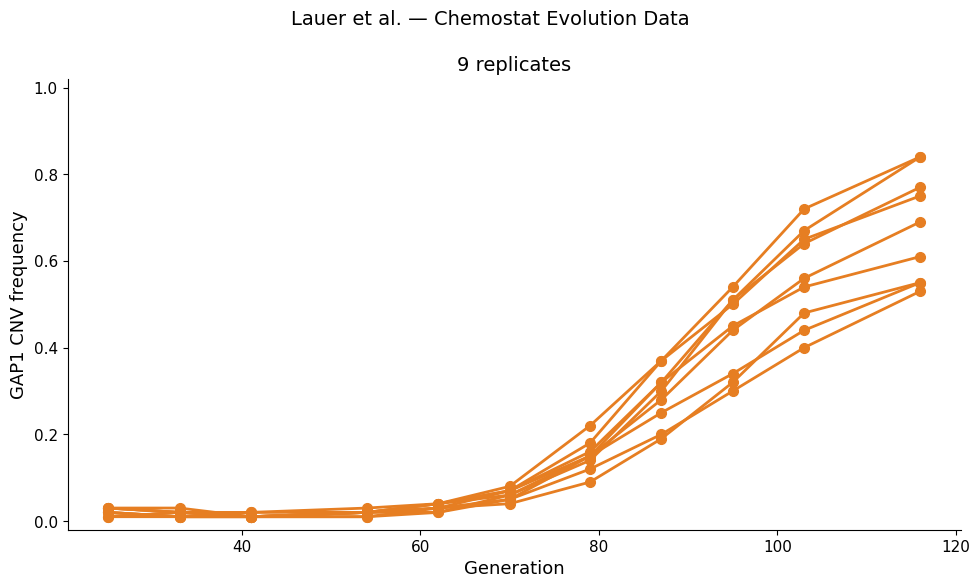

In [445]:
fig, ax = plt.subplots(figsize=(10, 6))

for j, (rep, row) in enumerate(lauer_df.iterrows()):
    ax.plot(LAUER_GEN, row.values, 'o-', color=C['avecilla_wf'], ms=7, lw=2)
ax.set_xlabel('Generation'); ax.set_ylabel('GAP1 CNV frequency')
ax.set_title('9 replicates')
ax.set_ylim(-0.02, 1.02); ax.legend(fontsize=9)


plt.suptitle('Lauer et al. — Chemostat Evolution Data', fontsize=14)
plt.tight_layout(); plt.show()


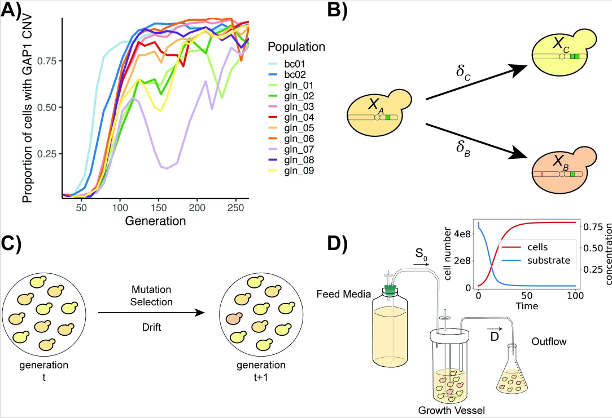

In [429]:
show_image('avecilla_wf_model.png')


### The model: 3-genotype Wright-Fisher

Two types of beneficial mutation arise from the ancestral genotype:
- A **GAP1 CNV** (amplification of the amino-acid permease gene)
- Other **beneficial mutations** (SNVs, other structural variants)

#### Genotypes

| Symbol | Genotype | Fitness |
|--------|----------|---------|
| $X_A$ | Ancestral (WT) | 1 |
| $X_C$ | GAP1 CNV | $1 + s_C$ |
| $X_B$ | Other beneficial mutation | $1 + s_B$ |

#### Discrete-generation update

**Mutation** (only ancestral cells mutate):
$$x_C^\dagger = x_A \delta_C + x_C, \quad x_B^\dagger = x_A \delta_B + x_B, \quad
  x_A^\dagger = (1 - \delta_C - \delta_B)\,x_A$$

**Selection**: $x_i^* = w_i x_i^\dagger / \bar{w}$

**Drift** ($N = 3.3 \times 10^8$):
$n_{t+1} \sim \mathrm{Multinomial}(N,\; x^*)$


In [430]:
def WF_Avecilla(log_delta_C, log_delta_B, s_C, s_B,
                generation, seed=None, N=int(3.3e8)):
    """
    Avecilla et al. 3-genotype Wright-Fisher simulator.

    Parameters
    ──────────
    log_delta_C : log10(CNV formation rate δ_C per generation)
    log_delta_B : log10(other-beneficial mutation rate δ_B per generation)
    s_C, s_B    : fitness advantages (linear scale)
    generation  : array of generation indices to return
    N           : effective population size (default 3.3 × 10^8)

    Returns: np.ndarray shape (len(generation), 3) — frequencies [x_A, x_C, x_B]
    """
    delta_C = 10 ** log_delta_C
    delta_B = 10 ** log_delta_B

    if seed is not None:
        np.random.seed(seed)

    w = np.array([1.0, 1.0 + s_C, 1.0 + s_B])
    M = np.array([
        [1 - delta_C - delta_B,  0,  0],
        [delta_C,                1,  0],
        [delta_B,                0,  1],
    ], dtype='float64')
    E = M @ np.diag(w)

    n = np.array([N, 0.0, 0.0])
    freqs = []
    for _ in range(int(generation.max()) + 1):
        freqs.append(n / n.sum())
        p = E @ (n / n.sum())
        p /= p.sum()
        n = np.random.multinomial(int(N), p).astype(float)

    return np.array(freqs)[generation.astype(int)]


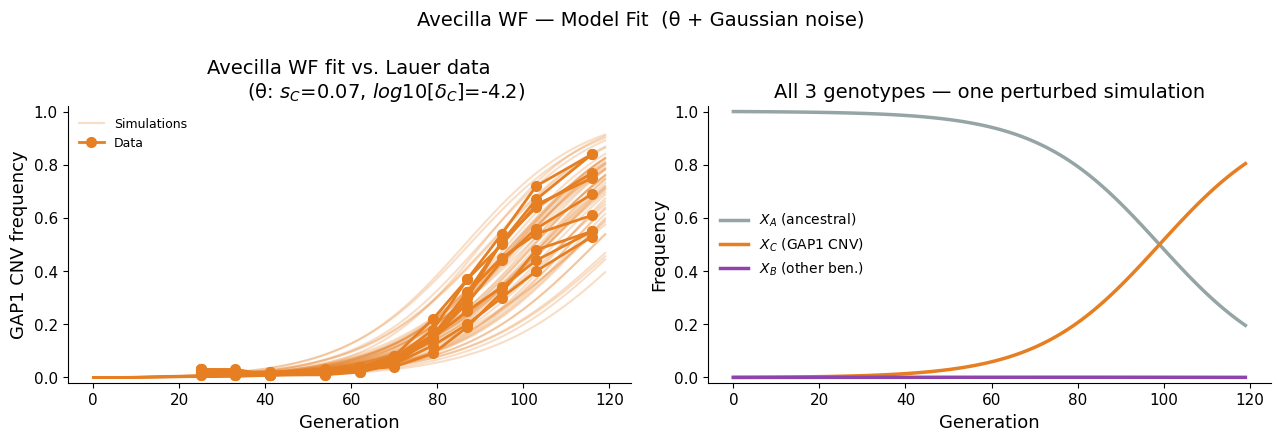

In [438]:
# ── Model fit: Avecilla WF vs. Lauer data ────────────────────────────────────
# Central theta (from Avecilla et al. / estimates) — adjust to improve the fit
THETA_AVE = dict(
    log_delta_C = -4.2,   # CNV formation rate
    log_delta_B = -5.0,   # other-beneficial rate
    s_C         =  0.07,  # CNV fitness advantage
    s_B         =  0.001, # other-beneficial fitness advantage
)
# Per-parameter noise std — controls how much replicates differ from each other
SIGMA_AVE = dict(
    log_delta_C = 0.2,
    log_delta_B = 0.2,
    s_C         = 0.005,
    s_B         = 0.005,
)

GEN_AVE = np.arange(120)
trajs   = noisy_sims(WF_Avecilla, THETA_AVE, SIGMA_AVE, n=50,
                     extra_kw=dict(generation=GEN_AVE))

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Panel A: simulation envelope + data
ax = axes[0]
for traj in trajs:
    ax.plot(GEN_AVE, traj[:, 1], lw=1.5, alpha=0.25, color=C['avecilla_wf'], label='Simulations' if traj is trajs[0] else None)
for j, (rep, row) in enumerate(lauer_df.iterrows()):
    ax.plot(LAUER_GEN, row.values, 'o-', color=C['avecilla_wf'], ms=7, lw=2, zorder=5, label='Data' if j == 0 else None)
from matplotlib.lines import Line2D
ax.legend(fontsize=9)
ax.set_xlabel('Generation'); ax.set_ylabel('GAP1 CNV frequency')

ax.set_title(f'Avecilla WF fit vs. Lauer data\n\
            (θ: $s_C$={THETA_AVE["s_C"]}, $log10[δ_C]$={THETA_AVE["log_delta_C"]})')
ax.set_ylim(-0.02, 1.02)

# Panel B: all 3 genotypes in one perturbed replicate
ax = axes[1]
rng = np.random.default_rng(0)
theta_ex = {k: v + rng.normal(0, SIGMA_AVE.get(k, 0)) for k, v in THETA_AVE.items()}
traj_ex  = WF_Avecilla(**theta_ex, generation=GEN_AVE, seed=0)
ax.plot(GEN_AVE, traj_ex[:, 0], lw=2.5, color='#95A5A6', label='$X_A$ (ancestral)')
ax.plot(GEN_AVE, traj_ex[:, 1], lw=2.5, color=C['avecilla_wf'], label='$X_C$ (GAP1 CNV)')
ax.plot(GEN_AVE, traj_ex[:, 2], lw=2.5, color='#8E44AD',  label='$X_B$ (other ben.)')
ax.set_xlabel('Generation'); ax.set_ylabel('Frequency')
ax.set_title('All 3 genotypes — one perturbed simulation')
ax.legend(fontsize=10); ax.set_ylim(-0.02, 1.02)

plt.suptitle('Avecilla WF — Model Fit  (θ + Gaussian noise)', fontsize=14)
plt.tight_layout(); plt.show()


## 2. Avecilla et al. — Chemostat ODE Model

---

### Why an ODE for chemostat evolution?

In a **chemostat**, cells grow continuously — not in discrete synchronized generations.
The ODE models nutrient-limited growth explicitly via **Monod kinetics**.

### Three genotypes with mutation

$$\frac{dX_A}{dt} = X_A\!\left(\mu_A - D\right) - (\delta_C + \delta_B)\,X_A$$
$$\frac{dX_C}{dt} = X_C\!\left(\mu_C - D\right) + \delta_C\,X_A$$
$$\frac{dX_B}{dt} = X_B\!\left(\mu_B - D\right) + \delta_B\,X_A$$
$$\frac{dS}{dt} = D(S_0 - S) - \frac{1}{Y}\!\left(X_A\mu_A + X_C\mu_C + X_B\mu_B\right)$$

with Monod kinetics $\mu_i = r_i S / (S + k)$ and $r_i = r_A(1 + s_i \ln 2)$.

### Parameters (Avecilla et al., Table 2)

| Symbol | Value | Meaning |
|--------|-------|---------|
| $D$ | 0.12 h⁻¹ | Dilution rate |
| $S_0$ | 0.8 mM | Influent glutamine |
| $k$ | 0.103 mM | Half-saturation (all genotypes) |
| $Y$ | 3.24 × 10⁷ cells mL⁻¹ mM⁻¹ | Yield |
| $r_A$ | 0.166 h⁻¹ | Ancestral max growth rate |

**Time axis**: hours. Conversion: 1 WF generation $= 1.5$ h (empirical chemostat value).


In [439]:
# Avecilla et al. Table 2 constants
D_AVE  = 0.12      # h⁻¹  dilution rate
S0_AVE = 0.8       # mM   influent substrate
K_AVE  = 0.103     # mM   half-saturation
Y_AVE  = 3.24e7    # cells/mL/mM  yield
R_A    = 0.166     # h⁻¹  ancestral max growth rate

GEN_TO_HOURS = 1.5   # hours per WF generation (empirical chemostat value)


def WF_Avecilla_ODE(log_delta_C, log_delta_B, s_C, s_B,
                    D=D_AVE, S0=S0_AVE, k=K_AVE, Y=Y_AVE, r_A=R_A,
                    t_max=700.0, n_points=1000):
    """
    Avecilla et al. chemostat ODE — 3 competing genotypes with mutation.

    Parameters use the same WF convention (per-generation s and δ), converted to per-hour:
        delta_per_hr = 10**log_delta / GEN_TO_HOURS
        r_C = r_A * (1 + s_C / (D * GEN_TO_HOURS))   # exact at steady state

    Returns: t_grid (hours), freqs shape (n_points, 3) — [x_A, x_C, x_B]
    """
    # Consistent with WF: at chemostat steady state, per-generation advantage = s_C
    # mu_C - mu_A = s_C / GEN_TO_HOURS  →  r_C = r_A * (1 + s_C/(D*GEN_TO_HOURS))
    r_C = r_A * (1 + s_C / (D * GEN_TO_HOURS))
    r_B = r_A * (1 + s_B / (D * GEN_TO_HOURS))
    # Per-hour mutation rate: delta_per_hr = delta_per_gen / GEN_TO_HOURS
    delta_C = 10**log_delta_C / GEN_TO_HOURS
    delta_B = 10**log_delta_B / GEN_TO_HOURS

    S_ss = D * k / (r_A - D)
    X_ss = Y * (S0 - S_ss)

    def odes(y, t):
        X_A, X_C, X_B, S = y
        S   = max(S,   1e-12)
        X_A = max(X_A, 0.0); X_C = max(X_C, 0.0); X_B = max(X_B, 0.0)
        mu_A = r_A * S / (S + k)
        mu_C = r_C * S / (S + k)
        mu_B = r_B * S / (S + k)
        dX_A = X_A * (mu_A - D) - (delta_C + delta_B) * X_A
        dX_C = X_C * (mu_C - D) + delta_C * X_A
        dX_B = X_B * (mu_B - D) + delta_B * X_A
        dS   = D * (S0 - S) - (X_A * mu_A + X_C * mu_C + X_B * mu_B) / Y
        return [dX_A, dX_C, dX_B, dS]

    t_grid = np.linspace(0, t_max, n_points)
    sol    = np.clip(odeint(odes, [X_ss, 0.0, 0.0, S_ss], t_grid), 0, None)
    X_tot  = sol[:, :3].sum(axis=1, keepdims=True)
    freqs  = sol[:, :3] / np.where(X_tot > 0, X_tot, 1)
    return t_grid, freqs


### Translating the ODE to WF language — and why it matters for inference

The ODE and WF share **the same parameters** (Fig below). The translation is:

| ODE parameter | WF parameter | Relationship |
|---------------|-------------|--------------|
| $r_C$ (max growth rate of CNV) | $s_C$ (selection coefficient) | $s_C = (r_C - r_A)/(r_A \ln 2)$ |
| $\delta_C^{\text{hr}}$ (per-hour mutation rate) | $\delta_C^{\text{gen}}$ (per-generation) | $\delta_C^{\text{gen}} = \delta_C^{\text{hr}} \cdot \ln 2 / D$ |
| Continuous time $t$ (hours) | Discrete generation $g$ | $g = t \cdot D / \ln 2$ |
| Total cells $= X_{ss} \times V$ | Effective population size $N$ | $N = Y(S_0 - S_{ss}) \times V$ |

**Consequence:** the Avecilla WF model IS the discrete-generation approximation of the ODE.
The Lauer data is measured in **generations**, so the WF model directly matches the time axis.

**For inferring the mutation rate** from Lauer data:
> Use `WF_Avecilla` with SBI — the posterior on `log_delta_C` is the per-generation
> CNV mutation rate. Convert to per-hour via $\delta^{\text{hr}} = 10^{\delta_C} \cdot D / \ln 2$.

The ODE adds nutrient dynamics ($S$) which matter for mechanistic understanding of
*why* selection coefficients have particular values — but for **parameter inference**
from population-frequency data, the WF is sufficient and faster to simulate.


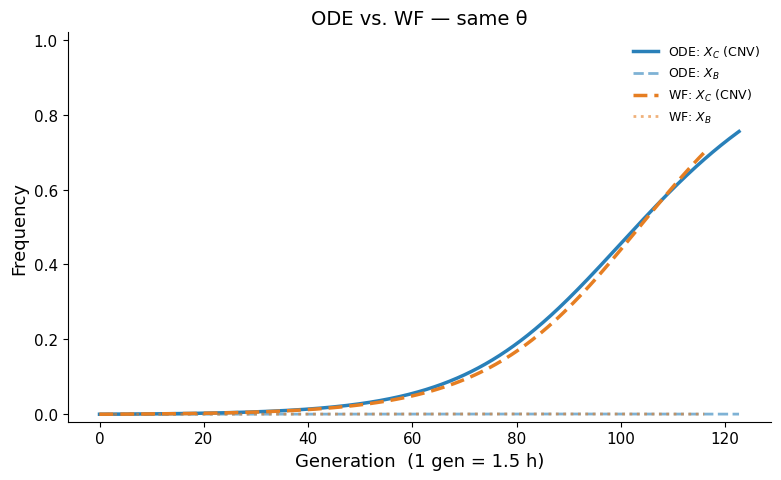

1 WF generation = 1.5 h
s_C = 0.07  →  r_C = 0.2306 h⁻¹  (steady-state advantage: 0.0700 per gen ≈ s_C)
δ_C = 10^-4.2 per gen  →  4.21e-05 h⁻¹ in ODE


In [440]:
# ── ODE vs WF: same WF parameters, generation axis ───────────────────────────
THETA_ODE = dict(log_delta_C=-4.2, log_delta_B=-5.0, s_C=0.07, s_B=0.001)

lauer_hours = LAUER_GEN * GEN_TO_HOURS
t_grid, freqs_ode = WF_Avecilla_ODE(**THETA_ODE, t_max=lauer_hours[-1] + 10)

gen_range = np.arange(int(LAUER_GEN[-1]) + 1)
traj_wf   = WF_Avecilla(**THETA_ODE, generation=gen_range, seed=42)

fig, ax = plt.subplots(figsize=(8, 5))

gen_axis = t_grid / GEN_TO_HOURS
ax.plot(gen_axis, freqs_ode[:, 1], lw=2.5, color=C['avecilla_ode'],
        label='ODE: $X_C$ (CNV)')
ax.plot(gen_axis, freqs_ode[:, 2], lw=2,   color=C['avecilla_ode'], ls='--',
        label='ODE: $X_B$', alpha=0.6)
ax.plot(gen_range, traj_wf[:, 1], lw=2.5, color=C['avecilla_wf'],
        ls=(0, (4, 2)), label='WF: $X_C$ (CNV)')
ax.plot(gen_range, traj_wf[:, 2], lw=2,   color=C['avecilla_wf'], ls=':',
        label='WF: $X_B$', alpha=0.6)

ax.set_xlabel(f'Generation  (1 gen = {GEN_TO_HOURS} h)')
ax.set_ylabel('Frequency')
ax.set_title('ODE vs. WF — same θ')
ax.legend(fontsize=9); ax.set_ylim(-0.02, 1.02)
plt.tight_layout(); plt.show()

print(f"1 WF generation = {GEN_TO_HOURS} h")
r_C_check = R_A * (1 + THETA_ODE['s_C'] / (D_AVE * GEN_TO_HOURS))
print(f"s_C = {THETA_ODE['s_C']}  →  r_C = {r_C_check:.4f} h⁻¹  "
      f"(steady-state advantage: {(r_C_check - R_A)*D_AVE/R_A*GEN_TO_HOURS:.4f} per gen ≈ s_C)")
print(f"δ_C = 10^{THETA_ODE['log_delta_C']} per gen  →  "
      f"{10**THETA_ODE['log_delta_C'] / GEN_TO_HOURS:.2e} h⁻¹ in ODE")


## 3. Chuong et al. — 4-Genotype Wright-Fisher

*(Chuong et al. 2025)*

---

### The data: LTRΔ discrete-generation evolution

*S. cerevisiae* was evolved in **discrete batch culture** for 116 generations.
Unlike the Avecilla chemostat, populations were passaged at fixed generation intervals.

- **7 replicate populations**
- **12 discrete generation time points**: [8, 21, 29, 37, 50, 58, 66, 79, 87, 95, 108, 116]
- **Observable**: GAP1 CNV⁺ frequency


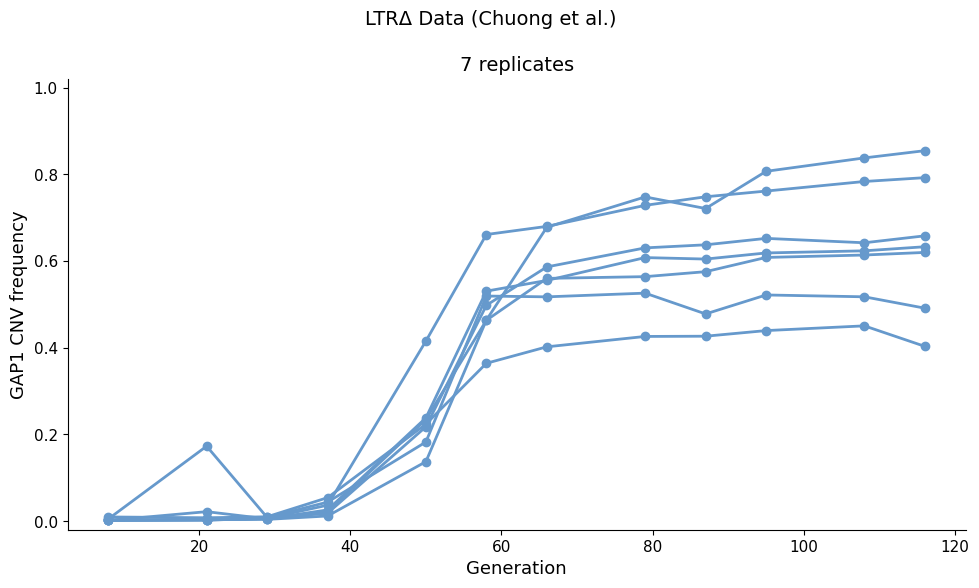

In [447]:
fig, ax = plt.subplots(figsize=(10, 6))


for j, (strain, row) in enumerate(ltr_df.iterrows()):
    ax.plot(LTR_GEN, row.values, 'o-', color=C['chuong'], ms=6, lw=2)
ax.set_xlabel('Generation'); ax.set_ylabel('GAP1 CNV frequency')
ax.set_title('7 replicates')
ax.set_ylim(-0.02, 1.02)

plt.suptitle('LTRΔ Data (Chuong et al.)', fontsize=14)
plt.tight_layout(); plt.show()


### Why Avecilla models don't fit LTR data

1. **Non-zero CNV at generation 8** — pre-existing CNV pool absent from Avecilla WF
2. **Different N** — chemostat N = 3.3×10⁸ vs LTR N ≈ 10⁷; drift is stronger here
3. **Chemostat ODE** — wrong time units and wrong population dynamics for batch culture


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


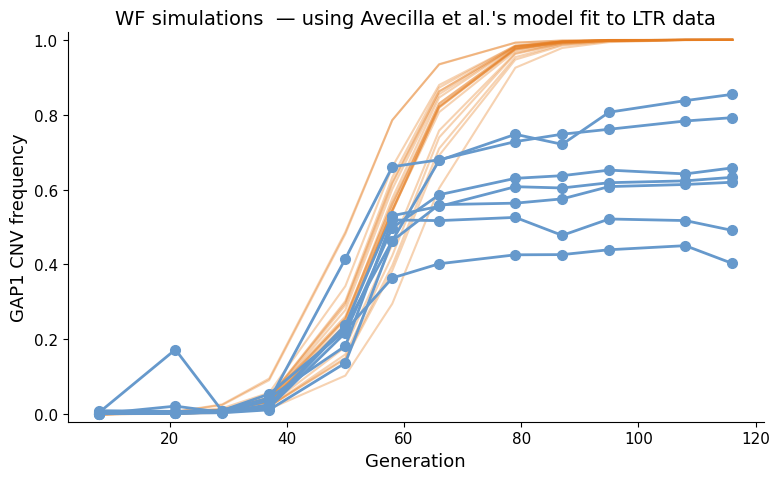

In [449]:
# Simulate with s=-0.74, delta=-4.84 in the wf model from avecilla
THETA_LTR = dict(log_delta_C=-4.84, log_delta_B=-5.0, s_C=10**(-0.74), s_B=0.001)
trajs_ltr = noisy_sims(WF_Avecilla, THETA_LTR, SIGMA_AVE, n=20,
                         extra_kw=dict(generation=LTR_GEN))
fig, ax = plt.subplots(figsize=(8, 5))
for traj in trajs_ltr:
    ax.plot(LTR_GEN, traj[:, 1], lw=1.5, alpha=0.35, color=C['avecilla_wf'])
for j, (rep, row) in enumerate(ltr_df.iterrows()):
    ax.plot(LTR_GEN, row.values, 'o-', color=C['chuong'], ms=7, lw=2, zorder=5)
ax.legend(fontsize=9)
ax.set_xlabel('Generation'); ax.set_ylabel('GAP1 CNV frequency')
ax.set_title(f"WF simulations  — using Avecilla et al.'s model fit to LTR data")
ax.set_ylim(-0.02, 1.02); plt.tight_layout(); plt.show()

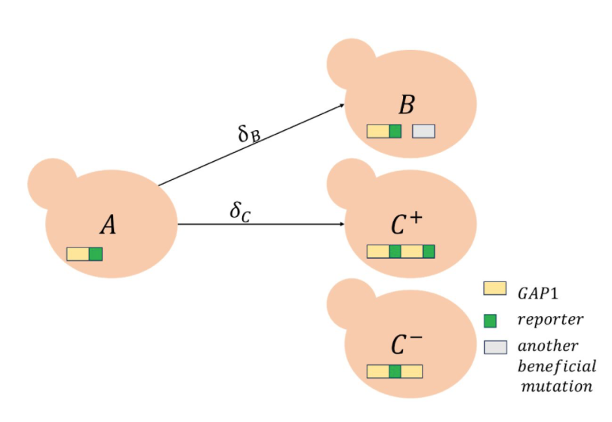

In [396]:
show_image('chuong_wf_model.png')


### The model: Chuong et al. 4-genotype Wright-Fisher

Key extension over the Avecilla WF:

**CNV⁻ pool** ($X_{C^-}$): pre-existing CNV cells explain non-zero CNV at generation 8

#### Genotypes

| Index | Genotype | Fitness | Initial frequency |
|-------|----------|---------|-------------------|
| 0 | WT (wild-type) | 1 | $1 - \varphi$ |
| 1 | CNV⁺ (new CNV) | $1 + s$ | $\approx 0$ (arises by mutation) |
| 2 | CNV⁻ (pre-existing) | $1 + s$ | $\varphi$ |
| 3 | SNV (point mutant) | $1 + s_{\text{snv}}$ | $\approx 0$ |

$$M = \begin{pmatrix}
1-\delta-\mu_{\text{snv}} & 0 & 0 & 0 \\
\delta & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
\mu_{\text{snv}} & 0 & 0 & 1
\end{pmatrix}, \quad E = M \cdot \text{diag}(w), \quad
n_{t+1} \sim \mathrm{Multinomial}(N,\; E\,p_t / |E p_t|)$$

$N = 3.3\cdot10^8$


In [397]:
S_SNV  = 1e-3
M_SNV  = 1e-5
N_CHU  = int(3.3e8)


def WF_Chuong(log_s, log_m, log_p0, seed=None):
    """
    Chuong et al. 4-genotype Wright-Fisher simulator.

    Parameters (log₁₀ scale)
    ────────────────────────
    log_s   : log10(CNV fitness benefit s)
    log_m   : log10(CNV mutation rate δ, WT→CNV⁺)
    log_p0  : log10(initial CNV⁻ fraction φ)

    Returns: np.array length 12 — CNV⁺ frequency at GENERATIONS
    """
    s, m, p0 = 10 ** np.array([log_s, log_m, log_p0])

    if seed is not None:
        np.random.seed(seed)

    w = np.array([1.0, 1.0 + s, 1.0 + s, 1.0 + S_SNV])
    M = np.array([
        [1 - m - M_SNV,  0,  0,  0],
        [m,              1,  0,  0],
        [0,              0,  1,  0],
        [M_SNV,          0,  0,  1],
    ], dtype='float64')
    E = M @ np.diag(w)

    n    = np.zeros(4)
    n[0] = N_CHU * (1 - p0)
    n[2] = N_CHU * p0

    cnv_freq = []
    for _ in range(int(GENERATIONS.max()) + 1):
        cnv_freq.append(n[1] / N_CHU)
        p = E @ (n / N_CHU); p /= p.sum()
        n = np.random.multinomial(N_CHU, p).astype(float)

    return np.array(cnv_freq)[GENERATIONS]


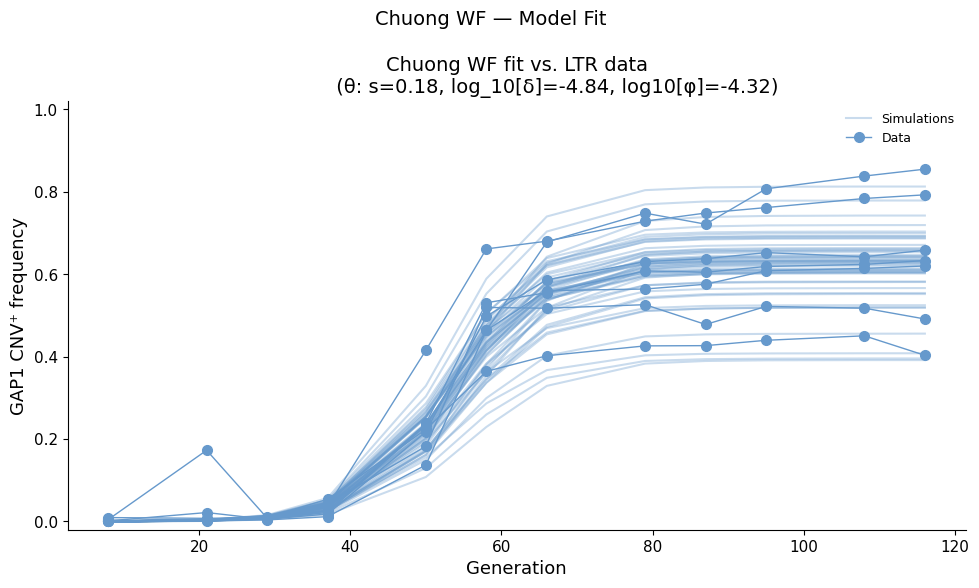

In [455]:
# ── Model fit: Chuong WF vs. LTR data ────────────────────────────────────────
THETA_CHU = dict(log_s=-0.74, log_m=-4.84, log_p0=-4.32)
SIGMA_CHU = dict(
    log_s  = 0.005,   
    log_m  = 0.1,    
    log_p0 = 0.1,
)

trajs_chu = noisy_sims(WF_Chuong, THETA_CHU, SIGMA_CHU, n=50)

fig, ax = plt.subplots(figsize=(10, 6))

# Panel A: simulations vs data
for traj in trajs_chu:
    ax.plot(GENERATIONS, traj, lw=1.5, alpha=0.35, color=C['chuong'], label='Simulations' if traj is trajs_chu[0] else "")
for j, (strain, row) in enumerate(ltr_df.iterrows()):
    ax.plot(LTR_GEN, row.values, 'o-', color=C['chuong'], ms=7, lw=1,
            label='Data' if j == 0 else "", zorder=5)
from matplotlib.lines import Line2D
ax.legend(fontsize=9)
ax.set_xlabel('Generation'); ax.set_ylabel('GAP1 CNV⁺ frequency')
ax.set_title(f'Chuong WF fit vs. LTR data\n\
             (θ: s={10**THETA_CHU["log_s"]:.2f}, log_10[δ]={THETA_CHU["log_m"]}, log10[φ]={THETA_CHU["log_p0"]})')
ax.set_ylim(-0.02, 1.02)


plt.suptitle('Chuong WF — Model Fit', fontsize=14)
plt.tight_layout(); plt.show()


## 4. De et al. — 2-Genotype Wright-Fisher

---

### The data: CNV fluorescent reporter assay

De et al. used **fluorescent reporter strains** to track CNV copy number dynamics.
The `Multicopy_mCitrine` column tracks cells with amplified (multicopy) GAP1 reporters.

- **Key strain**: DGY1886
- **Observable**: `Multicopy_mCitrine` (%) — fraction of cells with amplified CNV
- **Note**: CNV starts **common** and **declines** as revertants take over


In [456]:
data = pd.read_csv('data/clean_data_exp_2.csv')

# Filter contaminated replicate
clean_data = data.drop(data[data['Strain']=='DGY2751_1'].index)

# Prep
num_lines = len(clean_data['Line'].unique())
num_strains_max = 4 # max strains per line
generation_de = np.array(data[data['Strain'] == 'DGY1886_1']['Generation'])

# Match color palettes
colors_mep = ['peru', 'orange', 'brown', 'orangered', 'sienna']
colors_gap = ['royalblue', 'limegreen', 'green', 'darkturquoise', 'steelblue']
color_g = 'steelblue'
color_m = 'sienna'
# Match strain names
line_mapping = {'DGY1886': 'G_4', 'DGY2748': 'GM_12', 'DGY2750': 'GM_13', 'DGY2751':'GM_14', 'DGY2755':'GM_15'}

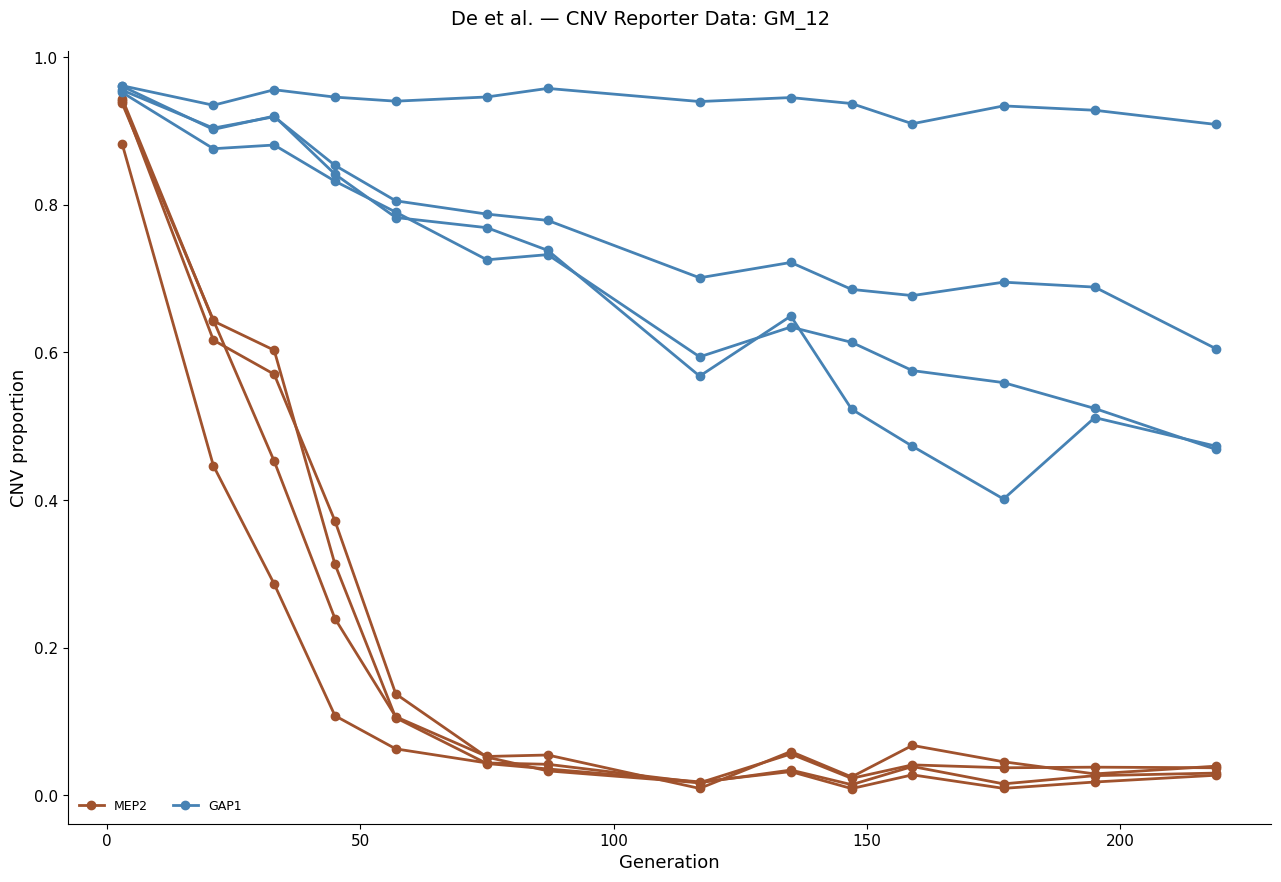

In [457]:
# plot DGY2748 - both mcherry and mcitrine, all replicates

line = 'DGY2748'
strain_focus = line_mapping[line]
de_sub = clean_data[clean_data['Line'] == line]

gap1_traj = de_sub['Multicopy_mCherry'].values
mep2_traj = de_sub['Multicopy_mCitrine '].values

fig, ax = plt.subplots(figsize=(13, 9))


for j, (rep, grp) in enumerate(de_sub.groupby('Strain')):
    ax.plot(grp['Generation'], grp['Multicopy_mCherry'], 'o-',
            color='sienna', ms=6, lw=2, label='MEP2' if j == 0 else "")

for j, (rep, grp) in enumerate(de_sub.groupby('Strain')):
    ax.plot(grp['Generation'], grp['Multicopy_mCitrine '], 'o-',
            color='steelblue', ms=6, lw=2, label='GAP1' if j == 0 else "")
ax.set_xlabel('Generation')
plt.suptitle(f'{strain_focus} — CNV Reporter Data', fontsize=14)

ax.set_xlabel('Generation'); ax.set_ylabel('CNV proportion')
plt.suptitle(f'De et al. — CNV Reporter Data: {strain_focus}', fontsize=14)
ax.legend(fontsize=9, ncol=2, loc='lower left')
plt.tight_layout(); plt.show()


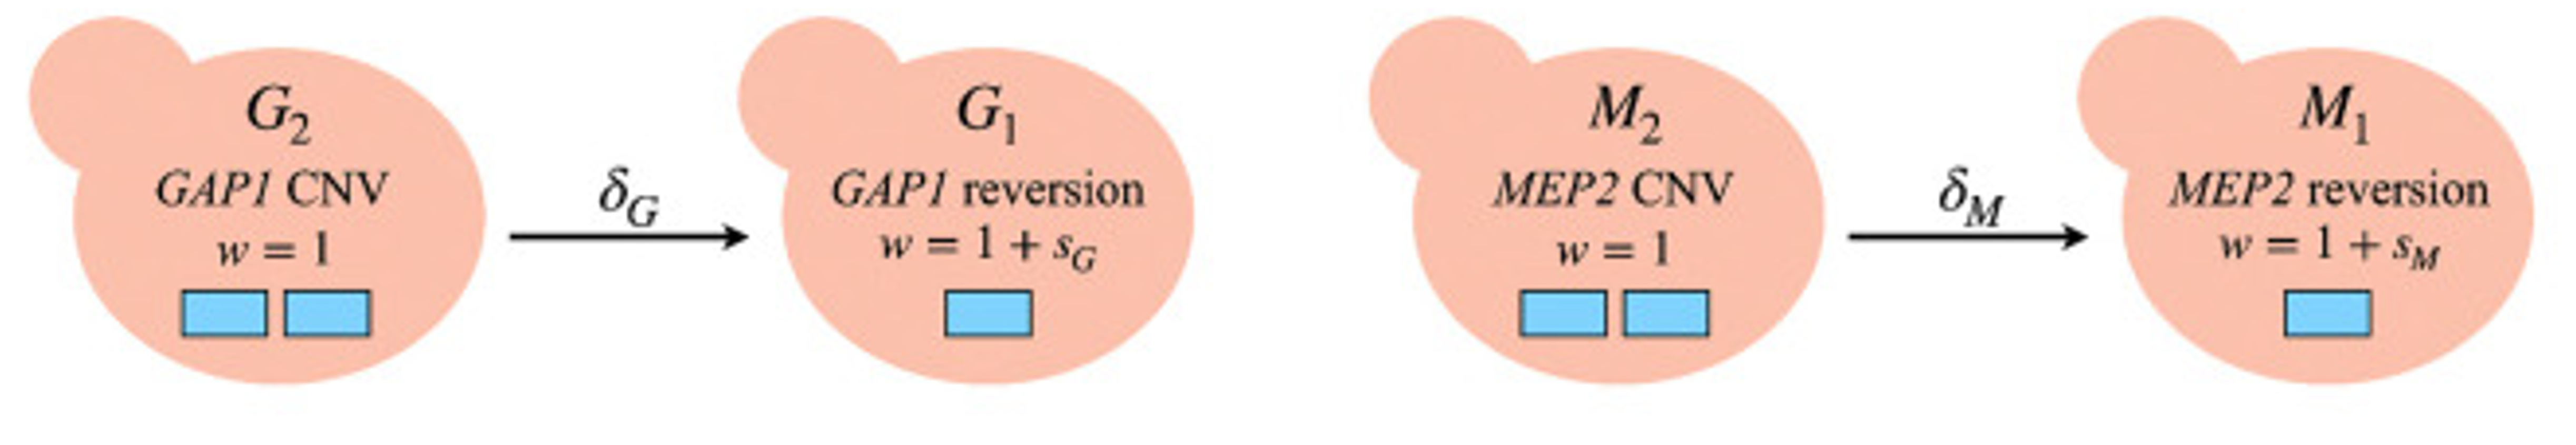

In [401]:
show_image('de_et_al_model.png')


### The model: De et al. 2-genotype WF (CNV reversion)

Asks the **opposite question** from Chuong: *How fast does an existing CNV revert?*

| Genotype | Fitness | Starts at |
|----------|---------|-----------|
| CNV (amplified) | 1 | 1-$\varphi$ |
| non-CNV (revertant) | $1 + s$ | $\varphi$ |

Mutation direction: CNV → non-CNV at rate $\delta$ (reversion).

$$M = \begin{pmatrix} 1 - \delta & 0 \\ \delta & 1 \end{pmatrix}, \quad
E = M \cdot \text{diag}(1,\, 1+s), \quad N = 1.9 \times 10^6$$


In [459]:
def WF_De(log_s, log_m, log_p0, generation=generation_de, seed=None, N=int(1.9e6)):
    """
    De et al. 2-genotype WF (CNV reversion).
    Genotype 0 = CNV (common), genotype 1 = non-CNV revertant (rare, fitness 1+s).
    Returns: np.array — CNV frequency at each generation.
    """
    s, m, p0 = 10 ** np.array([log_s, log_m, log_p0])
    if seed is not None:
        np.random.seed(seed)

    E = np.array([[1 - m, 0], [m, 1]], dtype='float64') @ np.diag([1.0, 1.0 + s])

    n = np.array([N * (1 - p0), N * p0])
    cnv_freq = []
    for _ in range(int(generation.max()) + 1):
        cnv_freq.append(n[0] / N)
        p = E @ (n / N); p /= p.sum()
        n = np.random.multinomial(N, p).astype(float)

    return np.array(cnv_freq)[generation.astype(int)]


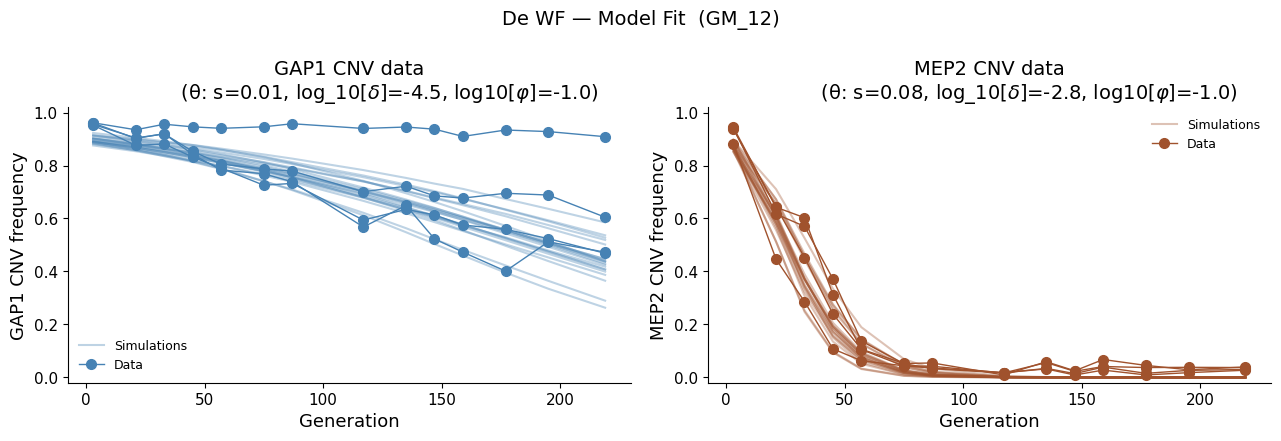

In [463]:
# ── Model fit: De et al. WF vs. reporter data ────────────────────────────────
# 2 fits - one for each reporter (mCherry = GAP1 CNV, mCitrine = MEP2 CNV)
# simulations are Chuong's green, gap1 cnv data is steelblue, mep2 cnv data is sienna
THETA_DE_GAP = dict(log_s=-1.95, log_m=-4.5, log_p0=-1.0)
THETA_DE_MEP = dict(log_s=-1.1, log_m=-2.8, log_p0=-1.0)
SIGMA_DE = dict(log_s=0.05, log_m=0.1, log_p0=0.05)
trajs_de_gap = noisy_sims(WF_De, THETA_DE_GAP, SIGMA_DE, n=20,
                          extra_kw=dict(generation=generation_de))
trajs_de_mep = noisy_sims(WF_De, THETA_DE_MEP, SIGMA_DE, n=20,
                          extra_kw=dict(generation=generation_de))

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))
# Panel A: GAP1 CNV (mCherry) — simulation envelope vs data
ax = axes[0]
for traj in trajs_de_gap:
    ax.plot(generation_de, traj, lw=1.5, alpha=0.35, color='steelblue', label='Simulations' if traj is trajs_de_gap[0] else '')
for j, (rep, grp) in enumerate(de_sub.groupby('Strain')):
    ax.plot(grp['Generation'], grp['Multicopy_mCitrine '], 'o-', color='steelblue',
            ms=7, lw=1, label='Data' if j == 0 else '', zorder=5)

ax.legend(fontsize=9)

ax.set_xlabel('Generation'); ax.set_ylabel('GAP1 CNV frequency')
ax.set_title(f'GAP1 CNV data\n\
             (θ: s={10**THETA_DE_GAP["log_s"]:.2f}, log_10[$\delta$]={THETA_DE_GAP["log_m"]}, log10[$\\varphi$]={THETA_DE_GAP["log_p0"]})')
ax.set_ylim(-0.02, 1.02)

# Panel B: MEP2 CNV (mCitrine) — simulation envelope vs data
ax = axes[1]
for traj in trajs_de_mep:
    ax.plot(generation_de, traj, lw=1.5, alpha=0.35, color='sienna', label='Simulations' if traj is trajs_de_mep[0] else '')
for j, (rep, grp) in enumerate(de_sub.groupby('Strain')):
    ax.plot(grp['Generation'], grp['Multicopy_mCherry'], 'o-', color='sienna',
            ms=7, lw=1, label='Data' if j == 0 else '', zorder=5)
ax.legend(fontsize=9)
ax.set_xlabel('Generation'); ax.set_ylabel('MEP2 CNV frequency')
ax.set_title(f'MEP2 CNV data\n\
             (θ: s={10**THETA_DE_MEP["log_s"]:.2f}, log_10[$\delta$]={THETA_DE_MEP["log_m"]}, log10[$\\varphi$]={THETA_DE_MEP["log_p0"]})')
ax.set_ylim(-0.02, 1.02)
plt.suptitle(f'De WF — Model Fit  ({strain_focus})', fontsize=14)
plt.tight_layout(); plt.show()

## 5. Zhou et al. — Aneuploidy Stability

---

### The data: Chr5 CNV GFP fluorescence tracking

Zhou et al. tracked chromosome aneuploidy stability using fluorescent reporters.
Cells carrying an extra Chr5 copy are identified by GFP fluorescence (AAB strain).

- **Sheet**: Chr5 CNV GFP
- **Populations tracked**: Trisomic (CNV GFP), WT (1:1 Ratio), LOH (GFP Only)
- **Time points**: passages [0, 1, 3, 5, 7, 10]


✓ Loaded 12 replicates × 6 passages × 3 genotypes
  Replicates: ['F5_1', 'F5_2', 'F5_3', 'F5_4', 'F5_5', 'F5_6', 'G9_1', 'G9_2', 'G9_3', 'G9_4', 'G9_5', 'G9_6']


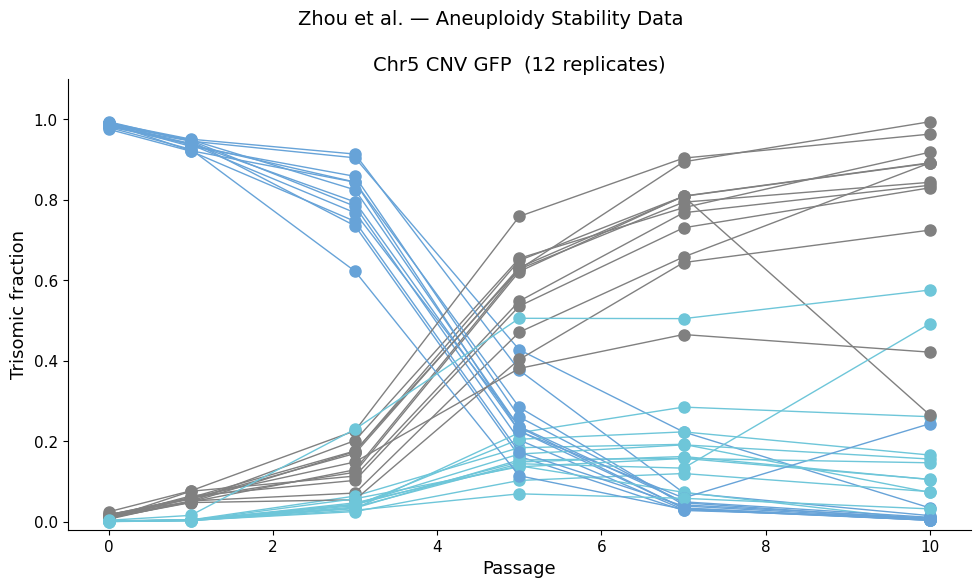

In [472]:
from evo_model import load_and_split_replicates

# ── Load Chr5 CNV GFP via evo_model (correct normalization + GFP logic) ───────
ZHOU_PASSAGES = np.array([0, 1, 3, 5, 7, 10])
ZHOU_SHEET    = 'Chr5 CNV GFP'
ZHOU_FILE     = 'data/Chr5 and Chr6 aneuploidies instability.xlsx'
ZHOU_COLORS   = ['#67A3D8', 'grey', '#6EC6D9']   # [Tri, WT, LOH]
ZHOU_LABELS   = ['Tri', 'WT', 'LOH']

rep_names, rep_data = load_and_split_replicates(
    file_path=ZHOU_FILE, well_id_sheet=ZHOU_SHEET
)
# rep_data : (N_reps, 6, 3)  —  columns = [Tri, WT, LOH] at each of 6 passages
print(f"✓ Loaded {len(rep_names)} replicates × {rep_data.shape[1]} passages × {rep_data.shape[2]} genotypes")
print(f"  Replicates: {rep_names}")

# ── Keep zhou_xl + zhou_tri_fracs available for the summary cell ───────────────
zhou_xl = pd.read_excel(ZHOU_FILE, sheet_name=None)
for sh in zhou_xl:
    zhou_xl[sh].columns = [c.strip() for c in zhou_xl[sh].columns]

def zhou_tri_fracs(df_sh):
    """Return {well_ID: (passages, tri_frac)} for a Zhou sheet (used by summary)."""
    tri_col = None
    for pop in df_sh['Population'].unique():
        if 'CNV' in str(pop) and 'Only' not in str(pop) and ':' not in str(pop):
            tri_col = pop; break
    wt_col  = '1:1 Ratio'
    loh_col = next((p for p in df_sh['Population'].unique() if 'Only' in str(p)), None)
    result  = {}
    for well, grp in df_sh.groupby('well_ID'):
        piv = grp.pivot_table(index='Passage', columns='Population',
                              values='population fraction', aggfunc='mean')
        cols = [c for c in [tri_col, wt_col, loh_col] if c and c in piv.columns]
        if len(cols) < 2:
            continue
        total = piv[cols].sum(axis=1)
        result[well] = (piv.index.values, piv[tri_col] / total)
    return result

# ── Plot ───────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))

# Panel A: per-replicate Tri trajectories (colored by replicate)

for j in range(len(rep_names)):
    for k, col in enumerate(ZHOU_COLORS):
        ax.plot(ZHOU_PASSAGES, rep_data[j, :, k],
                color=col, ms=8, lw=1, marker='o', zorder=5)
ax.set_xlabel('Passage'); ax.set_ylabel('Trisomic fraction')
ax.set_title(f'{ZHOU_SHEET}  ({len(rep_names)} replicates)')
ax.set_ylim(-0.02, 1.1)

plt.suptitle(f'Zhou et al. — Aneuploidy Stability Data', fontsize=14)
plt.tight_layout(); plt.show()


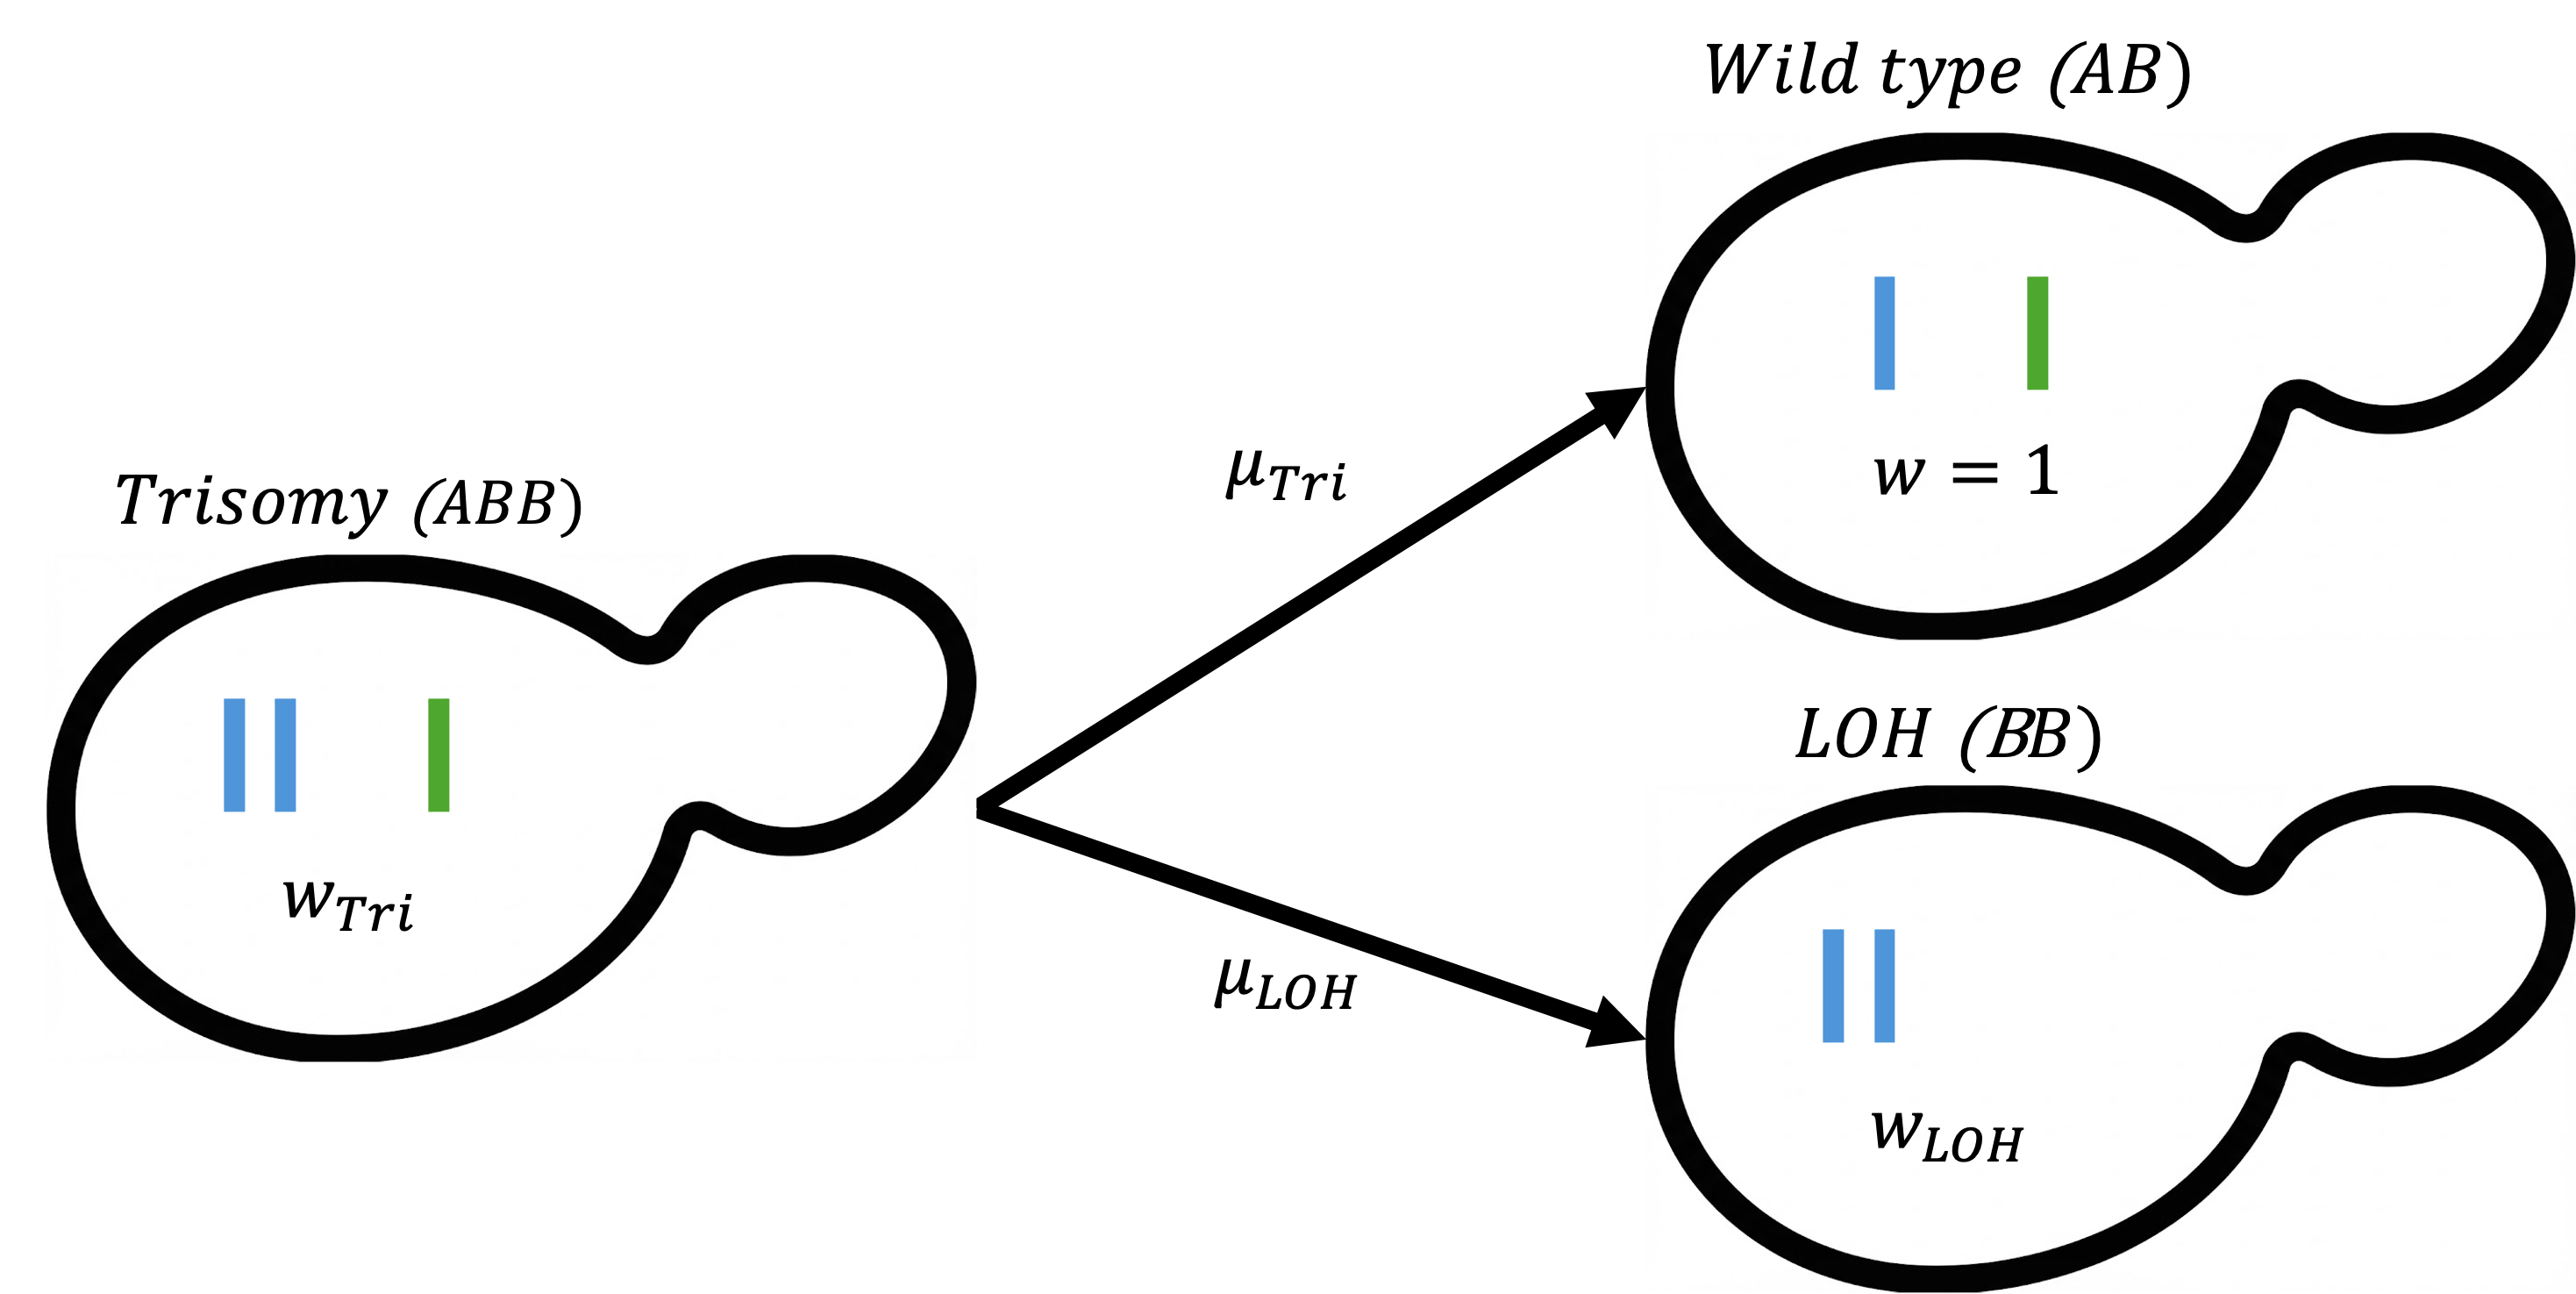

In [405]:
show_image('zhou_model.png')


### The model: Zhou et al. aneuploidy stability WF

Three genotypes: trisomic cells lose the extra chromosome via two pathways.

| Symbol | Genotype | Fitness | Starts at |
|--------|----------|---------|-----------|
| Tri | Trisomic (aneuploid) | $w_\text{tri}$ | ~100% |
| WT | Euploid (diploid) | 1 | ~0% |
| LOH | Loss of heterozygosity | $w_\text{loh}$ | ~0% |

$$M = \begin{pmatrix}
1 - \mu_\text{tri} - \mu_\text{loh} & 0 & 0 \\
\mu_\text{tri} & 1 & 0 \\
\mu_\text{loh} & 0 & 1
\end{pmatrix}, \quad G = \text{diag}(w_\text{tri},\,1,\,w_\text{loh}) \cdot M$$

Drift: $n_{t+1} \sim \text{Multinomial}(N_e,\; G\,p_t / |G\,p_t|)$, $N_e = 10^5$


In [406]:
def zhou_model(mu_tri, mu_loh, w_tri, w_loh,
               p_0=[1, 0, 0], N_e=100_000, generations=100,
               ret_gens=None, noise=0):
    """
    Zhou et al. aneuploidy stability WF simulator.

    Three genotypes: Tri (aneuploid) → WT or LOH via chromosome loss.

    Parameters (inferred via SBI/ABC)
    ──────────────────────────────────
    mu_tri : log10(Tri → WT transition rate per generation)
    mu_loh : log10(Tri → LOH transition rate per generation)
    w_tri  : trisomic fitness (linear scale, typically <1 — deleterious)
    w_loh  : LOH genotype fitness (linear scale)

    Transition matrix (mutate, then select):
        G = S @ M
        M[0,0] = 1 - mu_tri - mu_loh  (Tri stays Tri)
        M[1,0] = mu_tri                (Tri → WT)
        M[2,0] = mu_loh                (Tri → LOH)
        S = diag(w_tri, 1, w_loh)

    Returns: np.ndarray shape (len(ret_gens), 3) — fractions [Tri, WT, LOH]
    """
    if ret_gens is None:
        ret_gens = list(10*ZHOU_PASSAGES)
    mu_tri = 10 ** mu_tri
    mu_loh = 10 ** mu_loh

    N = np.array(np.array(p_0) * N_e, dtype=int)
    S = np.diag([w_tri, 1.0, w_loh])
    M = np.array([[1 - mu_tri - mu_loh, 0, 0],
                  [mu_tri,               1, 0],
                  [mu_loh,               0, 1]])
    G = S @ M  # mutate then select

    p = [N / N.sum()]
    for _ in range(generations + 1):
        N_t = G @ N
        N_t = np.random.multinomial(N_e, N_t / N_t.sum()) / N_e
        p.append(N_t)
        N = np.array(N_t * N_e, dtype=int)

    ret = np.array(p)[ret_gens]
    if noise > 0:
        ret += np.random.normal(0, noise, ret.shape)
    return ret

print("✓ zhou_model defined")
print("  Inferred parameters: mu_tri (log10), mu_loh (log10), w_tri, w_loh")


✓ zhou_model defined
  Inferred parameters: mu_tri (log10), mu_loh (log10), w_tri, w_loh


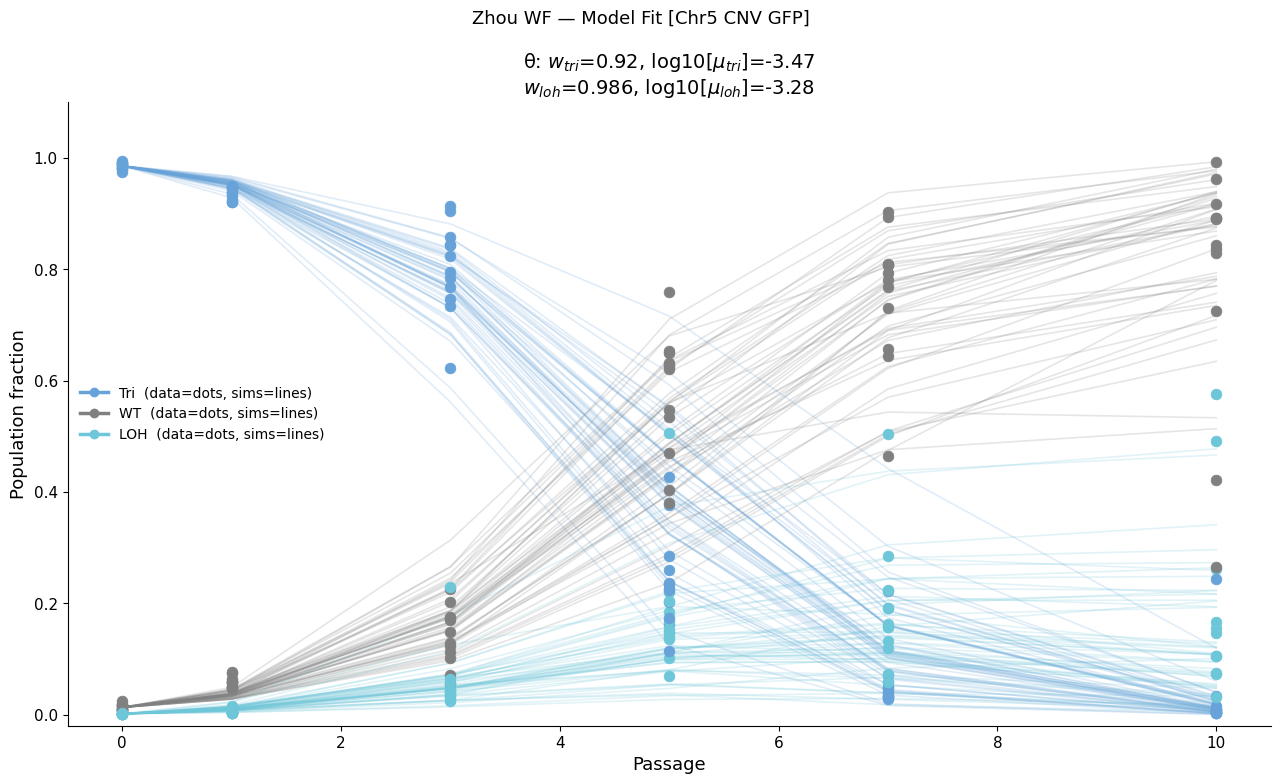

In [409]:
# ── Model fit: zhou_model vs. Chr5 CNV GFP data ──────────────────────────────
# 1 passage = 10 generations  →  ret_gens = 10 × ZHOU_PASSAGES
THETA_ZHOU = dict(
    mu_tri  = np.log10(3.4e-4),   # log10 Tri→WT rate
    mu_loh  = np.log10(5.3e-4),   # log10 Tri→LOH rate
    w_tri   =  0.92,  # trisomic fitness
    w_loh   =  0.986,  # LOH fitness
)
SIGMA_ZHOU = dict(
    mu_tri = 0.2,
    mu_loh = 0.2,
    w_tri  = 0.01,
    w_loh  = 0.01,
)
ZHOU_KW = dict(p_0=rep_data[:,0].mean(0), N_e=100_000, generations=100,
               ret_gens=list((10 * ZHOU_PASSAGES).astype(int)), noise=0)


def zhou_noisy_sims(theta, sigma, n=50):
    results = []
    for i in range(n):
        rng = np.random.default_rng(i)
        th  = {k: v + rng.normal(0, sigma.get(k, 0)) for k, v in theta.items()}
        np.random.seed(i)
        results.append(zhou_model(**th, **ZHOU_KW))
    return results


trajs_zhou = zhou_noisy_sims(THETA_ZHOU, SIGMA_ZHOU)

fig, axes = plt.subplots(1, 1, figsize=(13, 8))

# Panel A: all 3 genotypes — sims (thin) + data (thick), same 3 colors
ax = axes
for sim in trajs_zhou:
    for k, col in enumerate(ZHOU_COLORS):
        ax.plot(ZHOU_PASSAGES, sim[:, k], lw=1.2, alpha=0.2, color=col)
for j in range(len(rep_names)):
    for k, col in enumerate(ZHOU_COLORS):
        ax.scatter(ZHOU_PASSAGES, rep_data[j, :, k],
                color=col, s=60, lw=0.5, label=rep_names[j] if k == 0 else '', zorder=5)
from matplotlib.lines import Line2D
ax.legend(handles=[
    Line2D([0],[0], color=ZHOU_COLORS[k], lw=2.5, ms=6, marker='o',
           label=f'{ZHOU_LABELS[k]}  (data=dots, sims=lines)')
    for k in range(3)
], fontsize=10)
ax.set_xlabel('Passage'); ax.set_ylabel('Population fraction')
ax.set_title(
    'θ: $w_{tri}$='+f'{THETA_ZHOU["w_tri"]}, '+'log10[$μ_{tri}$]='+f'{THETA_ZHOU["mu_tri"]:.2f}\n'+\
    '$w_{loh}$='+f'{THETA_ZHOU["w_loh"]}, '+'log10[$μ_{loh}$]='+f'{THETA_ZHOU["mu_loh"]:.2f}')
ax.set_ylim(-0.02, 1.1)

plt.suptitle(
    f'Zhou WF — Model Fit [{ZHOU_SHEET}]',
    fontsize=13)
plt.tight_layout(); plt.show()


## Summary

---

### Five simulators compared

| | Avecilla WF | Avecilla ODE | Chuong WF | De et al. WF | Zhou WF |
|---|---|---|---|---|---|
| **Genotypes** | 3 (A/C/B) | 3 (A/C/B) | 4 (WT/CNV⁺/CNV⁻/SNV) | 2 (CNV/non-CNV) | 3 (Tri/WT/LOH) |
| **Time axis** | Generations | Hours | Generations | Generations | Passages |
| **N** | 3.3 × 10⁸ | Continuous | 10⁷ | 1.9 × 10⁶ | 10⁵ |
| **Mutation direction** | A → C, B | A → C, B (continuous) | WT → CNV⁺ | CNV → non-CNV | Tri → WT or LOH |
| **WF = ODE?** | ✓ (same θ) | ✓ (discrete approx.) | — | — | — |
| **Infer mutation rate via SBI?** | ✓ log_delta_C | (use WF instead) | ✓ log_m | ✓ log_m | ✓ mu_tri, mu_loh |

---

### Fitting strategy: θ + Gaussian noise

Each simulation draws $\theta_i \sim \mathcal{N}(\theta_{\text{central}}, \sigma)$,
where $\sigma$ represents between-replicate variation in biological parameters.
This separates two sources of variation in the data:

- **Drift** (within-replicate stochasticity): captured by the multinomial sampling
- **Parameter variation** (between-replicate differences in CNV rates, fitness): captured by $\sigma$

The central $\theta$ and $\sigma$ can be refined by matching the **median** and **spread**
of simulations to the data. For systematic inference, use SBI — see `SBI_tutorial.ipynb`.


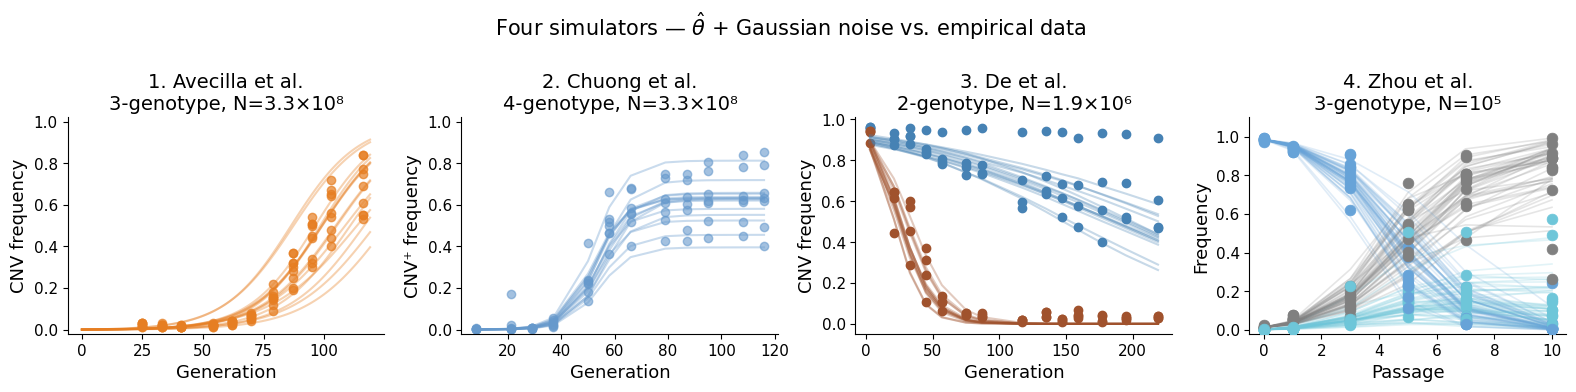

In [480]:
# ── Final figure: one perturbed trajectory from each simulator ───────────────
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# 1. Avecilla WF
ax = axes[0]
for traj in noisy_sims(WF_Avecilla, THETA_AVE, SIGMA_AVE, n=15,
                       extra_kw=dict(generation=np.arange(120))):
    ax.plot(np.arange(120), traj[:, 1], lw=1.5, alpha=0.35, color=C['avecilla_wf'])
for j, (_, row) in enumerate(lauer_df.iterrows()):
    ax.plot(LAUER_GEN, row.values, 'o', color=C['avecilla_wf'], ms=6, alpha=0.7)
ax.set_title('1. Avecilla et al.\n\
3-genotype, N=3.3×10⁸')
ax.set_xlabel('Generation'); ax.set_ylabel('CNV frequency')
ax.set_ylim(-0.02, 1.02)



# 3. Chuong WF
ax = axes[1]
for traj in trajs_chu[:15]:
    ax.plot(GENERATIONS, traj, lw=1.5, alpha=0.35, color=C['chuong'])
for j, (_, row) in enumerate(ltr_df.iterrows()):
    ax.plot(LTR_GEN, row.values, 'o', color=C['chuong'], ms=6, alpha=0.6)
ax.set_title('2. Chuong et al.\n\
4-genotype, N=3.3×10⁸')
ax.set_xlabel('Generation'); ax.set_ylabel('CNV⁺ frequency')
ax.set_ylim(-0.02, 1.02)

# 4. De et al.
ax = axes[2]
for traj in trajs_de_gap[:15]:
    ax.plot(generation_de, traj, lw=1.5, alpha=0.3, color='steelblue')
for traj in trajs_de_mep[:15]:
    ax.plot(generation_de, traj, lw=1.5, alpha=0.3, color='sienna')
for j, (rep, grp) in enumerate(de_sub.groupby('Strain')):
    ax.scatter(grp['Generation'], grp['Multicopy_mCitrine '],  color='steelblue')
for j, (rep, grp) in enumerate(de_sub.groupby('Strain')):
    ax.scatter(grp['Generation'], grp['Multicopy_mCherry'], color='sienna')

ax.set_title('3. De et al.\n\
2-genotype, N=1.9×10⁶')
ax.set_xlabel('Generation'); ax.set_ylabel('CNV frequency')

# 5. Zhou et al.

ax = axes[3]

for sim in trajs_zhou:
    for k, col in enumerate(ZHOU_COLORS):
        ax.plot(ZHOU_PASSAGES, sim[:, k], lw=1.2, alpha=0.2, color=col)
for j in range(len(rep_names)):
    for k, col in enumerate(ZHOU_COLORS):
        ax.scatter(ZHOU_PASSAGES, rep_data[j, :, k],
                color=col, s=60, lw=0.5, label=rep_names[j] if k == 0 else '', zorder=5)
        

ax.set_xlabel('Passage'); ax.set_ylabel('Population fraction')
ax.set_title(
    'θ: $w_{tri}$='+f'{THETA_ZHOU["w_tri"]}, '+'log10[$μ_{tri}$]='+f'{THETA_ZHOU["mu_tri"]:.2f}\n'+\
    '$w_{loh}$='+f'{THETA_ZHOU["w_loh"]}, '+'log10[$μ_{loh}$]='+f'{THETA_ZHOU["mu_loh"]:.2f}')
ax.set_ylim(-0.02, 1.1)

# fracs5 = zhou_tri_fracs(zhou_xl['Chr5 CNV GFP'])
# for j, (well, (passes, tri)) in enumerate(fracs5.items()):
#     ax.plot(passes, tri, 'o', color=REP_COLORS[j % 12], ms=6, alpha=0.8)
ax.set_title('4. Zhou et al.\n\
3-genotype, N=10⁵')
ax.set_xlabel('Passage'); ax.set_ylabel('Frequency')
ax.set_ylim(-0.02, 1.1)

plt.suptitle('Four simulators — $\hat{θ}$ + Gaussian noise vs. empirical data', fontsize=15)
plt.tight_layout(); plt.show()
